In [ ]:
!pip install ucimlrepo tensorflow scikit-learn pandas numpy matplotlib seaborn -q

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow import keras
from tensorflow.keras import layers
from ucimlrepo import fetch_ucirepo

dataset = fetch_ucirepo(id=374)
X = dataset.data.features
y = dataset.data.targets

y = y["Appliances"]

print("Размер данных:", X.shape, y.shape)
X.head()

Размер данных: (19735, 28) (19735,)


,date,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-1117:00:00,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,17.033333,45.53,6.60,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-1117:10:00,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,17.066667,45.56,6.48,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-1117:20:00,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,17.000000,45.50,6.37,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-1117:30:00,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,17.000000,45.40,6.25,733.8,92.0,6.000000,51.500000,5.0,45.410390,45.410390
4,2016-01-1117:40:00,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,17.000000,45.40,6.13,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [ ]:

X = X.drop(columns=["date"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Размер обучающей выборки:", X_train_scaled.shape)
print("Размер тестовой выборки:", X_test_scaled.shape)

Размер обучающей выборки: (15788, 27)
Размер тестовой выборки: (3947, 27)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error

tf.random.set_seed(42)
np.random.seed(42)

def build_rbm_pretrained_model(input_dim, rbm_stack):
    model = keras.Sequential()
    model.add(layers.Input(shape=(input_dim,)))

    prev_dim = input_dim

    for rbm in rbm_stack:
        W, hb = rbm.W.numpy(), rbm.hb.numpy()

        dense = layers.Dense(rbm.n_hidden, activation="relu")

        dense.build((None, prev_dim))

        dense.set_weights([W, hb])

        model.add(dense)
        prev_dim = rbm.n_hidden

    model.add(layers.Dense(1))

    model.compile(
        optimizer="adam",
        loss="mse",
        metrics=[keras.metrics.MeanAbsolutePercentageError()]
    )
    return model
==
model = build_rbm_pretrained_model(X_train_scaled.shape[1], rbm_stack)

print(model.summary())

history = model.fit(
    X_train_scaled,
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    verbose=1
)

y_pred = model.predict(X_test_scaled)
mape = mean_absolute_percentage_error(y_test, y_pred)

print("\n=================================")
print(f"MAPE after RBM pretraining: {mape:.4f}")
print("=================================")


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 128)            │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,897 (50.38 KB)

 Trainable params: 12,897 (50.38 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 14396.4443 - mean_absolute_percentage_error: 74.3892 - val_loss: 9754.5869 - val_mean_absolute_percentage_error: 71.2440
Epoch 2/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9785.5156 - mean_absolute_percentage_error: 64.8130 - val_loss: 9104.5918 - val_mean_absolute_percentage_error: 68.0225
Epoch 3/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9230.7979 - mean_absolute_percentage_error: 62.8824 - val_loss: 8839.8730 - val_mean_absolute_percentage_error: 67.5550
Epoch 4/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8959.6279 - mean_absolute_percentage_error: 61.7602 - val_loss: 8686.4971 - val_mean_absolute_percentage_error: 67.3387
Epoch 5/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8804.9541 - mean_absolute_percentage_error: 60.9106 - val_loss: 8579.8770 - val_mean_absolute_percentage_error: 67.1128
Epoch 6/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8702.7559 - mean_absolute_percent

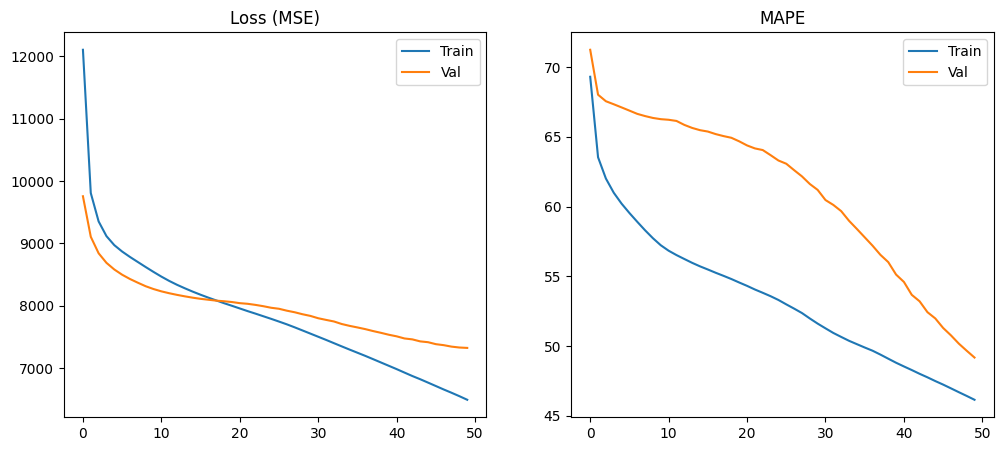

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss (MSE)")
plt.legend(["Train", "Val"])

plt.subplot(1,2,2)
plt.plot(history.history['mean_absolute_percentage_error'])
plt.plot(history.history['val_mean_absolute_percentage_error'])
plt.title("MAPE")
plt.legend(["Train", "Val"])

plt.show()
